In [14]:
import matplotlib.pyplot as plt
import sys
import os
import torch
import pickle
sys.path.append("/home/alec/latent-space-localization")
import auto_localization.dataset_management.data_manager_factory as data_manager_factory
import auto_localization.models.model_factory as model_factory
from auto_localization.localization.noise_model_selector import NoiseModelSelector
import numpy as np
%matplotlib inline

In [7]:
dataset_config = {
    "component_weighting": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], # weights slant and thickness
    "attribute_return": True,
    "which_digits": [1],
    "one_two_ratio": 0.0,
    "batch_size": 256,
    "indexed": True,
    "num_workers": 6,
    "single_feature_triplet": False,
    "inject_triplet_noise": 0.0,
    "dataset_name": "MorphoMNIST",
    "input_shape": (32, 32),
    "triplet_batch_size": 256
}
data_manager, localization_metadata_oracle = data_manager_factory.construct_morpho_mnist(dataset_config)

Setting up data


In [8]:
def load_experiment_config(wandb_path):
    # load up the experiment parameters from the given run_name
    run_directory = os.path.join(os.environ["LATENT_PATH"], "auto_localization", "logs", wandb_path)
    # load the expeirment config
    params_path = run_directory + "/params.pkl"
    with open(params_path, "rb") as f:
        experiment_config = pickle.load(f)
    
    return experiment_config

def load_model(wandb_path):
    # get the directory
    run_directory = os.path.join(os.environ["LATENT_PATH"], "auto_localization", "logs", wandb_path)
    # get the model config
    experiment_config = load_experiment_config(wandb_path)
    model_config = experiment_config["model_config"]
    # get the model path
    model_weight_path = os.path.join(run_directory, "best_model.pkl")
    # use the model factory to load the model
    model = model_factory.get_model_from_config(model_config["model_type"], model_config)
    # load the model weights
    model.load_state_dict(torch.load(model_weight_path))
    model.eval()
    return model

model = load_model("fresh-energy-1040").cuda()

In [11]:
def plot_response_model_probabilities(model, triplet_dataset, use_basic_setting=True):
    noise_model_selector = NoiseModelSelector(model, triplet_dataset=triplet_dataset, localizer_type="RandomLogistic")
    # evaluate the triplets
    triplets = noise_model_selector.evaluate_triplets()
    # evaluate the logistic response model
    if use_basic_setting:
        best_setting = {"k": 1.0, "normalization":0}
    else:
        best_setting = noise_model_selector.perform_brute_force(triplets)
    logistic_probs = noise_model_selector.compute_success_probabilities(best_setting, triplets)
    logistic_probs = np.stack(logistic_probs).squeeze()
    # evaluate the triplet response model
    noise_model_selector = NoiseModelSelector(model, triplet_dataset=triplet_dataset, localizer_type="RandomTriplet")
    if use_basic_setting:
        best_setting = {"k": 1.0, "normalization":0}
    else:
        best_setting = noise_model_selector.perform_brute_force(triplets)
    triplet_probs = noise_model_selector.compute_success_probabilities(best_setting, triplets)
    triplet_probs = np.stack(triplet_probs).squeeze()
    # make a violin plot of the evaluated response model probabilities
    fig, ax = plt.subplots(1, 1)
    ax.violinplot([triplet_probs, logistic_probs])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Triplet', 'Logistic'])
    ax.set_ylabel("Probabilities")
    plt.show()

  1%|          | 20/2000 [00:00<00:10, 193.19it/s]

evaluating triplets


100%|██████████| 2000/2000 [00:07<00:00, 273.60it/s]


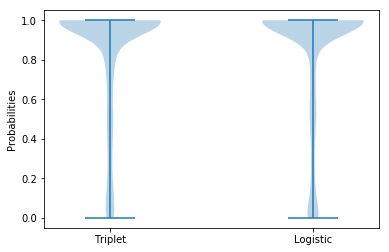

In [15]:
triplet_dataset = data_manager.triplet_test
plot_response_model_probabilities(model, triplet_dataset)
